Compiling model...
Building feed-forward neural network...
'build' took 0.083811 s

'compile' took 0.621279 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.52e-03, 9.21e-02, 7.66e-01]    [8.52e-03, 9.21e-02, 7.66e-01]    []  
1000      [4.23e-02, 9.52e-04, 6.08e-02]    [4.23e-02, 9.52e-04, 6.08e-02]    []  
2000      [3.24e-02, 1.47e-04, 5.02e-02]    [3.24e-02, 1.47e-04, 5.02e-02]    []  
3000      [3.02e-02, 1.57e-04, 4.59e-02]    [3.02e-02, 1.57e-04, 4.59e-02]    []  
4000      [2.27e-02, 6.06e-05, 3.48e-02]    [2.27e-02, 6.06e-05, 3.48e-02]    []  
5000      [7.67e-03, 7.07e-05, 6.72e-03]    [7.67e-03, 7.07e-05, 6.72e-03]    []  
6000      [3.82e-03, 1.23e-05, 2.83e-03]    [3.82e-03, 1.23e-05, 2.83e-03]    []  
7000      [2.76e-03, 5.81e-06, 2.28e-03]    [2.76e-03, 5.81e-06, 2.28e-03]    []  
8000      [2.37e-03, 4.71e-06, 1.97e-03]    [2.37e-03, 4.71e-06, 1.97e-03]    []  
9000      [2.51e-03, 5.37e-06, 1.

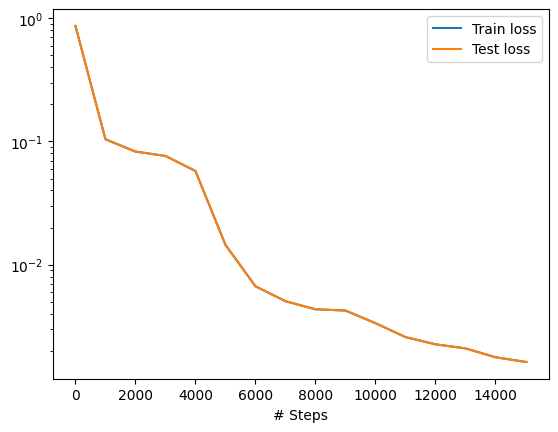

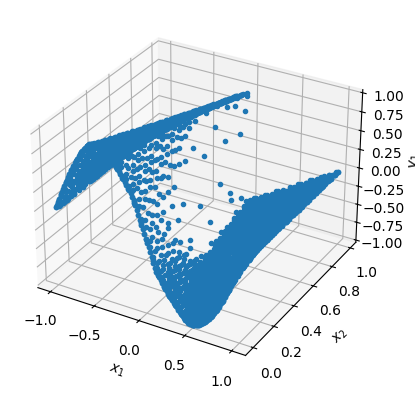

Mean residual: 0.018453732
L2 relative error: 0.08410697796893611


In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np


def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [6]:
print(data)